# Validation Example for PINT paper

A comparison between PINT result and Tempo/Tempo2 result. This example is presented in the PINT paper to validate that PINT is able to process the PSR J1600-3053 NANOGrav 11-year data set, which uses DD binary model, and get a comparable result with TEMPO/TEMPO2. For more discussion see: https://arxiv.org/abs/2012.00074  

This comparison includes the following steps:
  * PINT run on PSR J1600-3053 NANOGrav 11-year data set
    * Create PINT pre-fit residuals.
    * Re-fit data using PINT.
    * Create PINT post-fit residuals. 
    * Obtain the PINT post-fit parameter values.
  * TEMPO run on PSR J1600-3053 NANOGrav 11-year data set
    * Create TEMPO pre-fit residuals.
    * Re-fit data using TEMPO.
    * Create TEMPO post-fit residuals.
    * Obtain the TEMPO post-fit parameter values.
    * Compare the pre-fit and post-fit residuals between PINT and TEMPO.
    * Compare the pre-fit and post-fit parameters between PINT and TEMPO.  
  * TEMPO2 run on PSR J1600-3053 NANOGrav 11-year data set
    * Create TEMPO2 pre-fit residuals.
    * Re-fit data using TEMPO2.
    * Create TEMPO2 post-fit residuals.
    * Obtain the TEMPO2 post-fit parameter values.
    * Compare the pre-fit and post-fit residuals between PINT and TEMPO2.
    * Compare the pre-fit and post-fit parameters between PINT and TEMPO2.

Method of this comparison:

   The method we used in this comparison starts from the published data set with a converged timing model. The data in this comparison are produced by TEMPO.
   0. The PINT pre-fit residuals and post-fit residuals should be close and no visible difference. If the post-fit and pre-fit residuals are very different, it means PINT has a bug or some different definitions of parameters(e.g., PINT DDK model has different definition of KOM parameter).  
   1. Compare the pre-fit residuals between PINT-TEMPO/TEMPO2, to see if there are outstanding discrepancies(residual difference > 10 ns, since we are aim to have our machine precision in the 1 ns level). These discrepancies are likely caused by different code implements and we try to verify the reasons(some of them are bugs in PINT or in TEMPO/TEMPO2, but some of them are just implementation choices). 
   2. Fit the data and compare the chi2 value and post-fit residuals between PINT and TEMPO/TEMPO2 to exam if the fitter returns a reasonable result(i.e., chi2 and post-fit rms do not deviate from TEMPO/TEMPO2's value too much, etc.). If the fit gives a "non-sense" result, that is worth to do more investigation. One of the useful indicators is the discrepancy of the post-fit residuals between PINT and TEMPO/TEMPO2. 
   3. Compare the post-fit parameters between PINT and TEMPO/TEMPO2. Since the initial parameter are from the same data, there should be not difference. The PINT post-fit parameters should change within the original uncertainties(TEMPO uncertainties), and the PINT uncertainty vs TEMPO/TEMPO2 uncertainty should be close. 
 
    
Requirement:
  * Data set: PRS J1600-3053 NANOGrav 11-year data 
    * One copy of PRS J1600-3053 NANOGrav 11-year data is included in the PINT source code `docs/examples/J1600-3053_NANOGrav_11yv1.gls.par` and `docs/examples/J1600-3053_NANOGrav_11yv1.tim`, which is the default data path in this notebook. Note, this requires the user to download the PINT source code from github.
    * The offical NANOGrav 11-year data can be downloaded at: https://data.nanograv.org/. The data path should be changed to the data location.
  * PINT version: 0.8.0 or higher.
  * TEMPO and its python utils tempo_utils. 
    * TEMPO version for current comparison: 13.101 (2020-11-04 c5fbddf)
  * TEMPO2 and its python utils tempo2_utils.
    * TEMPO2 version for current comparison:  2019.01.1
  * TEMPO_utils and TEMPO2_utils are packaged together and can be downloaded from https://github.com/demorest/tempo_utils. 
  * TEMPO2 general2 plugins. 


In [1]:
import pint
import sys
from pint import toa
from pint import models
from pint.fitter import GLSFitter
import os
import matplotlib.pyplot as plt
import astropy.units as u
import tempo2_utils as t2u
import tempo_utils
import tempo2_utils
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import subprocess
import tempfile
from pint import ls
import astropy.constants as ct
from pint.solar_system_ephemerides import objPosVel_wrt_SSB
from astropy.time import Time

### Print the PINT and TEMPO/TEMPO2 version

In [2]:
print("PINT version: ", pint.__version__)
tempo_v = subprocess.check_output(["tempo", "-v"])
print("TEMPO version: ", tempo_v.decode("utf-8"))
# Not sure why tempo2_v = subprocess.check_output(["tempo2", "-v"]) does not work.
process = subprocess.Popen(["tempo2", "-v"], stdout=subprocess.PIPE)
tempo2_v = process.communicate()[0]
print("TEMPO2 version: ", tempo2_v.decode("utf-8"))

PINT version:  0.8+68.g6c072c27
TEMPO version:   Tempo v 13.101 (2020-11-04 c5fbddf)

TEMPO2 version:  2019.01.1



### Redefine the Tempo2_util function for larger number of observations

In [3]:
_nobs = 30000


def newpar2(parfile, timfile):
    """
    Run tempo2, return new parfile (as list of lines).  input parfile
    can be either lines or a filename.
    """
    orig_dir = os.getcwd()
    try:
        temp_dir = tempfile.mkdtemp(prefix="tempo2")
        try:
            lines = open(parfile, "r").readlines()
        except:
            lines = parfile
        open("%s/pulsar.par" % temp_dir, "w").writelines(lines)
        timpath = os.path.abspath(timfile)
        os.chdir(temp_dir)
        cmd = "tempo2 -nobs %d -newpar -f pulsar.par %s -norescale" % (_nobs, timpath)
        os.system(cmd + " > /dev/null")
        outparlines = open("new.par").readlines()
    finally:
        os.chdir(orig_dir)
    os.system("rm -rf %s" % temp_dir)
    for l in outparlines:
        if l.startswith("TRES"):
            rms = float(l.split()[1])
        elif l.startswith("CHI2R"):
            (foo, chi2r, ndof) = l.split()
    return float(chi2r) * float(ndof), int(ndof), rms, outparlines

### Set up date file path for PSR J1600-3053. 

* Note
  * This path only works when PINT is installed from source code, which has docs and example directories.

In [4]:
psr = "J1600-3053"
par_file = os.path.join("../examples", psr + "_NANOGrav_11yv1.gls.par")
tim_file = os.path.join("../examples", psr + "_NANOGrav_11yv1.tim")

## PINT run

### Load TOAs to PINT

In [5]:
t = toa.get_TOAs(tim_file, ephem="DE436", bipm_version="BIPM2015")

INFO: Applying clock corrections (include_gps = True, include_bipm = True) [pint.toa]
INFO: Observatory gbt, loading clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/time.dat [pint.observatory.topo_obs]
INFO: Applying observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading GPS clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/gps2utc.clk [pint.observatory.topo_obs]
INFO: Applying TT(TAI) to TT(BIPM2015) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading BIPM clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/tai2tt_bipm2015.clk [pint.observatory.topo_obs]
INFO: Computing TDB columns. [pint.toa]
INFO: Using EPHEM = DE436 for TDB calculation. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE436 [pint.toa]
INFO: Set solar system ephemeris to li

In [6]:
print("There are {} TOAs in the dataset.".format(t.ntoas))

There are 12433 TOAs in the dataset.


### Load timing model from .par file

Since PINT only uses the IAU 2000 version of precession-nutation model but NANOGrav 11-year data uses old precession-nutation model, You will see a UserWarning: `PINT only supports 'T2CMETHOD IAU2000B'`. 

In [7]:
m = models.get_model(par_file)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")


### Make the General Least Square fitter

In [8]:
f = GLSFitter(model=m, toas=t)

### Fit TOAs for 9 iterations.

The expected chi2 value should be close to TEMPO and TEMPO2, but not the same.

In [9]:
chi2 = f.fit_toas(9)
print("Postfit Chi2: ", chi2)
print("Degree of freedom: ", f.resids.dof)

/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT

Postfit Chi2:  12368.094375740437515
Degree of freedom:  12307



### The weighted RMS value for pre-fit and post-fit residuals

In [10]:
print("Pre-fit residual weighted RMS:", f.resids_init.rms_weighted())
print("Post-fit residual weighted RMS:", f.resids.rms_weighted())

Pre-fit residual weighted RMS: 0.944170684867224 us
Post-fit residual weighted RMS: 0.9441138383219785 us


### Plot the pre-fit and post-fit residuals

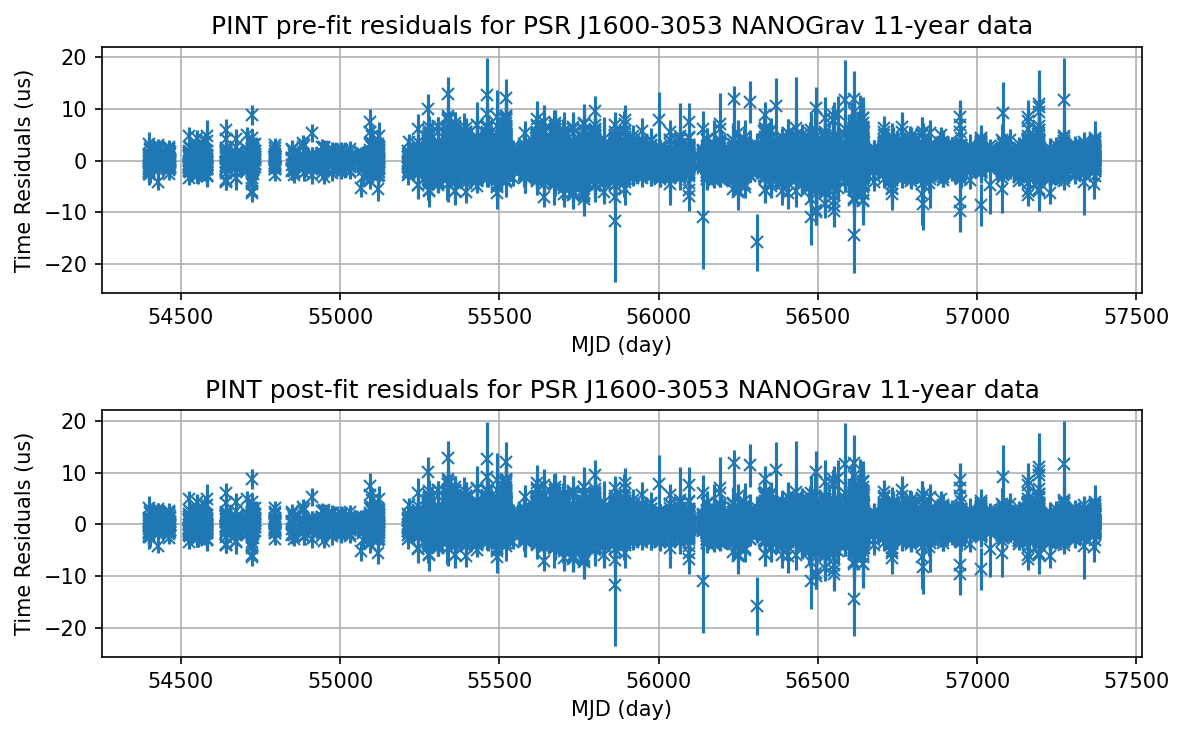

In [11]:
pint_prefit = f.resids_init.time_resids.to_value(u.us)
pint_postfit = f.resids.time_resids.to_value(u.us)

plt.figure(figsize=(8, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.errorbar(
    t.get_mjds().to_value(u.day),
    f.resids_init.time_resids.to_value(u.us),
    yerr=t.get_errors().to_value(u.us),
    fmt="x",
)

plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (us)")
plt.title("PINT pre-fit residuals for PSR J1600-3053 NANOGrav 11-year data")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.errorbar(
    t.get_mjds().to_value(u.day),
    f.resids.time_resids.to_value(u.us),
    yerr=t.get_errors().to_value(u.us),
    fmt="x",
)
plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (us)")
plt.title("PINT post-fit residuals for PSR J1600-3053 NANOGrav 11-year data")
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT")

## TEMPO run

### Use tempo_utils to analysis the same data set.

In [12]:
tempo_toa = tempo_utils.read_toa_file(tim_file)
tempo_chi2, ndof, rms_t, tempo_par = tempo_utils.run_tempo(
    tempo_toa, par_file, get_output_par=True, gls=True
)

In [13]:
print("TEMPO postfit chi2: ", tempo_chi2)
print("TEMPO postfit weighted rms: ", rms_t)

TEMPO postfit chi2:  12368.46
TEMPO postfit weighted rms:  0.944


### Write the TEMPO postfit model to a new .par file, for comparison later

In [14]:
# Write out the post fit tempo parfile.
tempo_parfile = open(psr + "_tempo.par", "w")
for line in tempo_par:
    tempo_parfile.write(line)
tempo_parfile.close()

### Get the TEMPO residuals

In [15]:
tempo_prefit = tempo_toa.get_prefit()
tempo_postfit = tempo_toa.get_resids()
mjds = tempo_toa.get_mjd()
freqs = tempo_toa.get_freq()
errs = tempo_toa.get_resid_err()

### Plot the PINT - TEMPO residual difference.

In [16]:
tp_diff_pre = (pint_prefit - tempo_prefit) * u.us
tp_diff_post = (pint_postfit - tempo_postfit) * u.us

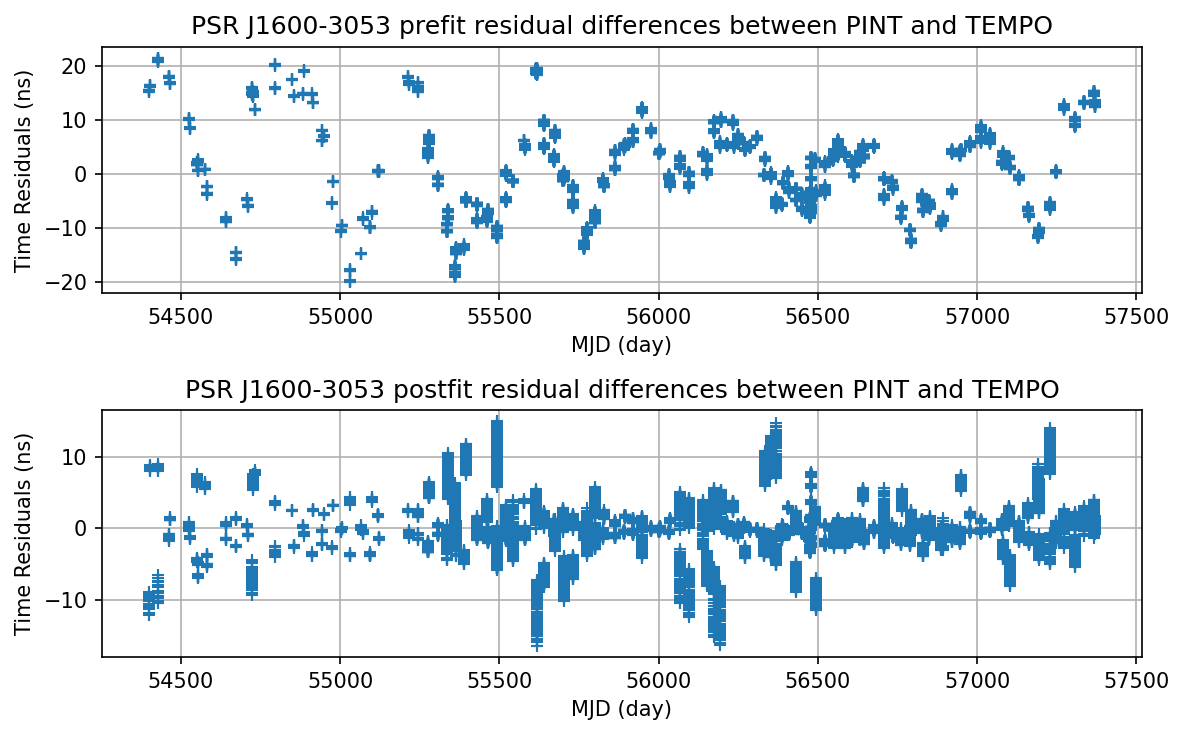

In [17]:
plt.figure(figsize=(8, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(mjds, (tp_diff_pre - tp_diff_pre.mean()).to_value(u.ns), "+")
plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (ns)")
plt.title("PSR J1600-3053 prefit residual differences between PINT and TEMPO")
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(mjds, (tp_diff_post - tp_diff_post.mean()).to_value(u.ns), "+")
plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (ns)")
plt.title("PSR J1600-3053 postfit residual differences between PINT and TEMPO")
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT_tempo.eps")

The PINT-TEMPO pre-fit residual discrepancy is due to the different precession-nutation model in the two packages.
* TEMPO: IAU6501976 precession and IAU 1980 nutation.
* PINT: IAU2000B precession-nutation.

### Compare the parameter between TEMPO and PINT

* Reported quantities
  * TEMPO value
  * TEMPO uncertainty 
  * Parameter units
  * TEMPO parameter value - PINT parameter value
  * TEMPO/PINT parameter absolute difference divided by TEMPO uncertainty 
  * PINT uncertainty divided by TEMPO uncertainty, if TEMPO provides the uncertainty value

In [18]:
# Create the parameter compare table
tv = []
tu = []
tv_pv = []
tv_pv_tc = []
tc_pc = []
units = []
names = []
no_t_unc = []
tempo_new_model = models.get_model(psr + "_tempo.par")
for param in tempo_new_model.params:
    t_par = getattr(tempo_new_model, param)
    pint_par = getattr(f.model, param)
    tempoq = t_par.quantity
    pintq = pint_par.quantity
    try:
        diffq = tempoq - pintq
        if t_par.uncertainty_value != 0.0:
            diff_tcq = np.abs(diffq) / t_par.uncertainty
            uvsu = pint_par.uncertainty / t_par.uncertainty
            no_t_unc.append(False)
        else:
            diff_tcq = np.abs(diffq) / pint_par.uncertainty
            uvsu = t_par.uncertainty
            no_t_unc.append(True)
    except TypeError:
        continue
    uvsu = pint_par.uncertainty / t_par.uncertainty
    tv.append(tempoq.value)
    tu.append(t_par.uncertainty.value)
    tv_pv.append(diffq.value)
    tv_pv_tc.append(diff_tcq.value)
    tc_pc.append(uvsu)
    units.append(t_par.units)
    names.append(param)

compare_table = Table(
    (names, tv, tu, units, tv_pv, tv_pv_tc, tc_pc, no_t_unc),
    names=(
        "name",
        "Tempo Value",
        "Tempo uncertainty",
        "units",
        "Tempo_V-PINT_V",
        "Tempo_PINT_diff/unct",
        "PINT_unct/Tempo_unct",
        "no_t_unc",
    ),
)
compare_table.sort("Tempo_PINT_diff/unct")
compare_table = compare_table[::-1]
compare_table.write("parameter_compare.t.html", format="html", overwrite=True)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")


### Print the parameter difference in a table.

The table is sorted by relative difference in descending order. 

In [19]:
compare_table

name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
ELONG,244.347677844079,5.9573e-09,deg,-5.923646156924533557e-10,0.09943508228433239147,0.99997665908491340815,False
ELAT,-10.0718390253651,3.36103e-08,deg,-3.1908024911500576515e-09,0.09493525767845147623,1.0000723294528560605,False
PMELONG,0.4626,0.010399999999999999523,mas / yr,0.00071186955533908413685,0.06844899570568116487,1.0031591658256824307,False
F0,277.9377112429746148,5.186e-13,Hz,-1.471045507628332416e-14,0.028365705893334601157,1.0000737060332136081,False
PX,0.504,0.07349999999999999589,mas,-0.0020714040496805363745,0.028182368022864442286,0.99982583641940803165,False
ECC,0.0001737294,8.9000000000000002855e-09,,-2.385671795204248602e-10,0.026805301069710657513,1.0022775158955208319,False
DMX_0010,0.00066927561,0.00020051850499999999489,pc / cm3,-5.0888210248638612865e-06,0.025378311218028786617,0.9999978605214362437,False
DMX_0001,0.0016432056,0.00022434462499999998828,pc / cm3,-5.3330253040537178855e-06,0.023771576003007506561,1.0000068595527518145,False
DMX_0002,0.00136024872,0.00020941304000000001188,pc / cm3,-4.909940340062750319e-06,0.023446201535791421494,1.0000106543543163529,False


### If one wants the Latex output please use the cell below. 

In [20]:
# ascii.write(compare_table, sys.stdout, Writer = ascii.Latex,
#            latexdict = {'tabletype': 'table*'})

### Check out the maximum DMX difference

In [21]:
max_dmx = 0
max_dmx_index = 0
for ii, row in enumerate(compare_table):
    if row["name"].startswith("DMX_"):
        if row["Tempo_PINT_diff/unct"] > max_dmx:
            max_dmx = row["Tempo_PINT_diff/unct"]
            max_dmx_index = ii

dmx_max = compare_table[max_dmx_index]["name"]

compare_table[max_dmx_index]

name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
DMX_0010,0.00066927561,0.00020051850499999999489,pc / cm3,-5.0888210248638612865e-06,0.025378311218028786617,0.9999978605214362437,False


### Output the table in the paper

In [22]:
paper_params = [
    "F0",
    "F1",
    "FD1",
    "FD2",
    "JUMP1",
    "PX",
    "ELONG",
    "ELAT",
    "PMELONG",
    "PMELAT",
    "PB",
    "A1",
    "A1DOT",
    "ECC",
    "T0",
    "OM",
    "OMDOT",
    "M2",
    "SINI",
    dmx_max,
]
# Get the table index of the parameters above
paper_param_index = []
for pp in paper_params:
    # We assume the parameter name are unique in the table
    idx = np.where(compare_table["name"] == pp)[0][0]
    paper_param_index.append(idx)
paper_param_index = np.array(paper_param_index)
compare_table[paper_param_index]

name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
F0,277.9377112429746148,5.186e-13,Hz,-1.471045507628332416e-14,0.028365705893334601157,1.0000737060332136081,False
F1,-7.338737472765e-16,4.619148184227e-21,Hz / s,6.3620434143467849095e-23,0.013773196183814252269,1.0001125817340140925,False
FD1,3.98314325e-05,1.6566479199999999207e-06,s,-2.5460168459788480762e-09,0.0015368484849688811896,0.9999972210804803918,False
FD2,-1.47296057e-05,1.1922595999999999884e-06,s,1.3701818969060749554e-09,0.0011492311715553180356,0.99999858894148907495,False
JUMP1,-8.789e-06,1.2999999999999999941e-07,s,-4.6499257614788852208e-10,0.0035768659703683731467,1.0037094619649047367,False
PX,0.504,0.07349999999999999589,mas,-0.0020714040496805363745,0.028182368022864442286,0.99982583641940803165,False
ELONG,244.347677844079,5.9573e-09,deg,-5.923646156924533557e-10,0.09943508228433239147,0.99997665908491340815,False
ELAT,-10.0718390253651,3.36103e-08,deg,-3.1908024911500576515e-09,0.09493525767845147623,1.0000723294528560605,False
PMELONG,0.4626,0.010399999999999999523,mas / yr,0.00071186955533908413685,0.06844899570568116487,1.0031591658256824307,False


## TEMPO2 run

Before TEMPO2 run, the `.par` file has to be modified for a more accurate TEMPO2 vs PINT comparison. We save the modified .par file in a file named "[PSR name]_tempo2.par". In this case, "J1600-3053_tempo2.par"

* Modified parameters in the .par file:
  * ECL IERS2010   ----> ECL IERS 2003 (In this version of TEMPO2, the IERS 2003 Obliquity angle is hardcoded in its code. To match TEMPO2's default value, we change the ECL to IERS 2003 in the `.par` file )
  * T2CMETHOD TEMPO  ----> # T2CMETHOD TEMPO (TEMPO2 supports both IAU 2000 precession-nutation model and old TEMPO-style model. To make TEMPO2 ues its default precession and nutation model, IAU 2000, this line in the `.par` file has to be commmented out.)
* Note, this modified `.par` file is provided in the `docs/examples` directory. If PINT is not installed from source code, one have to modify the `.par` file from the NANOGrav 11-year data.

In [23]:
tempo2_par = os.path.join("../examples", "J1600-3053_tempo2.par")

### PINT refit using the modified tempo2-style parfile

In [24]:
m_t2 = models.get_model(tempo2_par)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


In [25]:
f_t2 = GLSFitter(toas=t, model=m_t2)
f_t2.fit_toas()

12368.092265853045861

### Tempo2 fit

In [26]:
tempo2_chi2, ndof, rms_t2, tempo2_new_par = newpar2(tempo2_par, tim_file)
print("TEMPO2 chi2: ", tempo2_chi2)
print("TEMPO2 rms: ", rms_t2)

TEMPO2 chi2:  12265.156200000001
TEMPO2 rms:  0.944


### Get TEMPO2 residuals, toa value, observing frequencies, and data error

In [27]:
tempo2_result = t2u.general2(
    tempo2_par, tim_file, ["sat", "pre", "post", "freq", "err"]
)
# TEMPO2's residual unit is second
tp2_diff_pre = f_t2.resids_init.time_resids - tempo2_result["pre"] * u.s
tp2_diff_post = f_t2.resids.time_resids - tempo2_result["post"] * u.s

### Plot the TEMPO2 - PINT residual difference

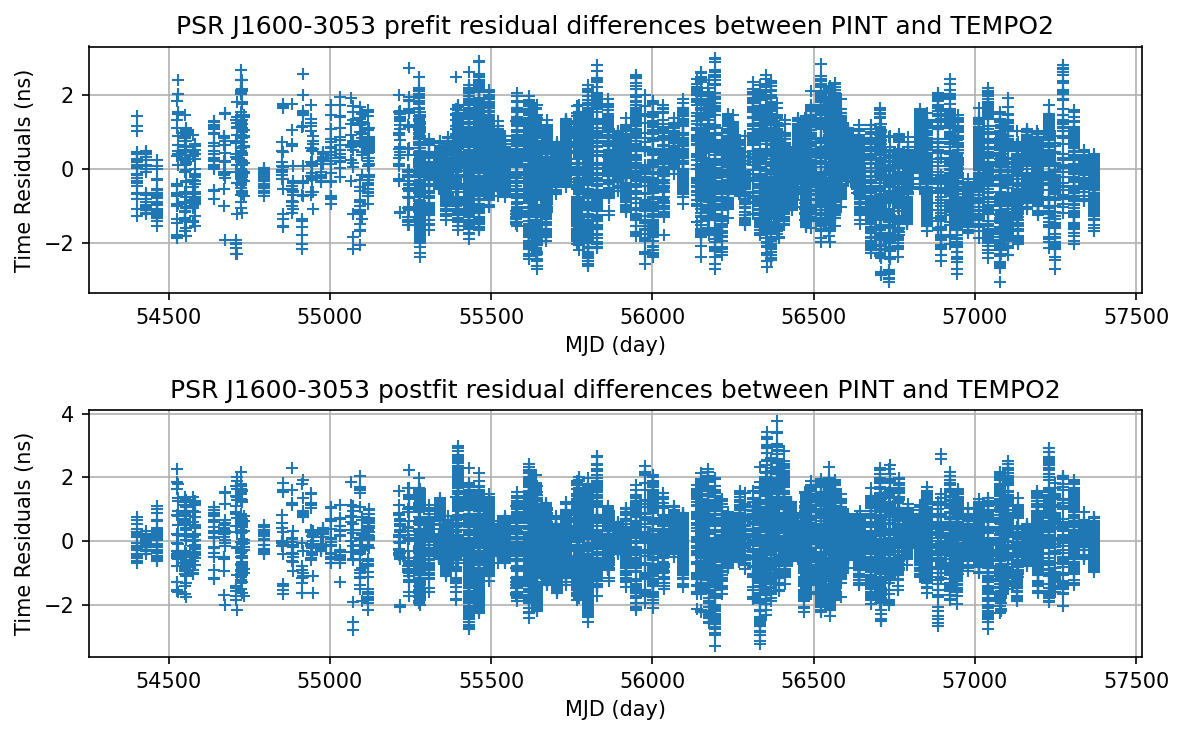

In [28]:
plt.figure(figsize=(8, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(mjds, (tp2_diff_pre - tp2_diff_pre.mean()).to_value(u.ns), "+")
plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (ns)")
plt.title("PSR J1600-3053 prefit residual differences between PINT and TEMPO2")
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(mjds, (tp2_diff_post - tp2_diff_post.mean()).to_value(u.ns), "+")
plt.xlabel("MJD (day)")
plt.ylabel("Time Residuals (ns)")
plt.title("PSR J1600-3053 postfit residual differences between PINT and TEMPO2")
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT_tempo2")

In this comparison, PINT and TEMPO2's results, both pre-fit and post-fit, agree with each other within the level of 5 ns.

### Write out the TEMPO2 postfit parameter to a new file

* Note, since the ECL parameter is hard coded in tempo2, we will have to add it manually 

In [29]:
# Write out the post fit tempo parfile.
tempo2_parfile = open(psr + "_new_tempo2.2.par", "w")
for line in tempo2_new_par:
    tempo2_parfile.write(line)
tempo2_parfile.write("ECL IERS2003")
tempo2_parfile.close()

### Compare the parameter between TEMPO2 and PINT

* Reported quantities
  * TEMPO2 value
  * TEMPO2 uncertainty 
  * Parameter units
  * TEMPO2 parameter value - PINT parameter value
  * TEMPO2/PINT parameter absolute difference divided by TEMPO2 uncertainty 
  * PINT uncertainty divided by TEMPO2 uncertainty, if TEMPO2 provides the uncertainty value

In [30]:
# Create the parameter compare table
tv = []
t2_unc = []
tv_pv = []
tv_pv_tc = []
tc_pc = []
units = []
names = []
no_t2_unc = []
tempo2_new_model = models.get_model(psr + "_new_tempo2.2.par")
for param in tempo2_new_model.params:
    t2_par = getattr(tempo2_new_model, param)
    pint2_par = getattr(f_t2.model, param)
    tempo2q = t2_par.quantity
    pint2q = pint2_par.quantity
    try:
        diff2q = tempo2q - pint2q
        if t2_par.uncertainty_value != 0.0:
            diff_tcq = np.abs(diff2q) / t2_par.uncertainty
            uvsu = pint2_par.uncertainty / t2_par.uncertainty
            no_t2_unc.append(False)
        else:
            diff_tcq = np.abs(diff2q) / pint2_par.uncertainty
            uvsu = t2_par.uncertainty
            no_t2_unc.append(True)
    except TypeError:
        continue
    uvsu = pint2_par.uncertainty / t2_par.uncertainty
    tv.append(tempo2q.value)
    t2_unc.append(t2_par.uncertainty.value)
    tv_pv.append(diff2q.value)
    tv_pv_tc.append(diff_tcq.value)
    tc_pc.append(uvsu)
    units.append(t2_par.units)
    names.append(param)

compare_table2 = Table(
    (names, tv, t2_unc, units, tv_pv, tv_pv_tc, tc_pc, no_t2_unc),
    names=(
        "name",
        "Tempo2 Value",
        "T2 unc",
        "units",
        "Tempo2_V-PINT_V",
        "Tempo2_PINT_diff/unct",
        "PINT_unct/Tempo2_unct",
        "no_t_unc",
    ),
)
compare_table2.sort("Tempo2_PINT_diff/unct")
compare_table2 = compare_table2[::-1]
compare_table2.write("parameter_compare.t2.html", format="html", overwrite=True)

/home/luo/.local/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Print the parameter difference in a table.
The table is sorted by relative difference in descending order. 

In [31]:
compare_table2

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
ECC,0.00017372966157521168,8.922286680669999241e-09,,4.158524756102052744e-11,0.0046608284455950449096,1.0000400945849889922,False
DMX_0098,0.0013394613122489417,0.00019579968831114546654,pc / cm3,-5.203720844662671624e-07,0.002657675755026450183,0.999999270898346615,False
DMX_0070,-0.00023747963906517973,0.00019767137320477682749,pc / cm3,-4.67328571424551701e-07,0.0023641691958118014015,1.0000006149827960211,False
DMX_0097,0.0013928330661987446,0.00019620100461426303326,pc / cm3,-4.3986846819175744183e-07,0.002241927706010230642,0.9999998585691036723,False
DMX_0055,-0.0005307704904403621,0.00019675128861832102923,pc / cm3,-3.9826563099699431592e-07,0.0020242085009648507626,1.0000000155754873443,False
DMX_0063,-0.00048410571072825574,0.00019894769104906708185,pc / cm3,-3.8863084052005031355e-07,0.001953432273934765668,1.0000001764728303488,False
DMX_0079,0.00018976795294000216,0.00019490725481464179483,pc / cm3,-3.6899448284041791446e-07,0.001893179826432496481,1.000000186999052243,False
DMX_0010,0.00067403356955979,0.00020051850482404336064,pc / cm3,-3.7725252445390284467e-07,0.0018813850860545018075,0.99999987947730495375,False
F1,-7.3387383041227678664e-16,4.619148404392432094e-21,Hz / s,-8.1916189706268323405e-24,0.0017734045874857090789,0.9999982063295332385,False


### If one wants to get the latex version, please use the line below.

In [32]:
# ascii.write(compare_table2, sys.stdout, Writer = ascii.Latex,
#            latexdict = {'tabletype': 'table*'})

### Check out the maximum DMX difference

In [33]:
max_dmx = 0
max_dmx_index = 0
for ii, row in enumerate(compare_table2):
    if row["name"].startswith("DMX_"):
        if row["Tempo2_PINT_diff/unct"] > max_dmx:
            max_dmx = row["Tempo2_PINT_diff/unct"]
            max_dmx_index = ii

dmx_max2 = compare_table2[max_dmx_index]["name"]

compare_table2[max_dmx_index]

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
DMX_0098,0.0013394613122489417,0.00019579968831114546654,pc / cm3,-5.203720844662671624e-07,0.002657675755026450183,0.999999270898346615,False


### Output the table in the paper

In [34]:
paper_params = [
    "F0",
    "F1",
    "FD1",
    "FD2",
    "JUMP1",
    "PX",
    "ELONG",
    "ELAT",
    "PMELONG",
    "PMELAT",
    "PB",
    "A1",
    "A1DOT",
    "ECC",
    "T0",
    "OM",
    "OMDOT",
    "M2",
    "SINI",
    dmx_max,
]
# Get the table index of the parameters above
paper_param_index = []
for pp in paper_params:
    # We assume the parameter name are unique in the table
    idx = np.where(compare_table2["name"] == pp)[0][0]
    paper_param_index.append(idx)
paper_param_index = np.array(paper_param_index)
compare_table2[paper_param_index]

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str48,float128,object,float128,float128,float128,bool
F0,277.93771124297462788,5.1859268946902080184e-13,Hz,-6.6613381477509392425e-16,0.0012845029023782387781,1.0000081311054239701,False
F1,-7.3387383041227678664e-16,4.619148404392432094e-21,Hz / s,-8.1916189706268323405e-24,0.0017734045874857090789,0.9999982063295332385,False
FD1,3.983282287426775e-05,1.6566478062738200598e-06,s,-1.6361212107284211874e-09,0.0009876095598185302606,1.00000000325577032,False
FD2,-1.4729805752137882e-05,1.1922596055992699934e-06,s,1.4357622807706935195e-09,0.0012042362871541143106,1.0000000135934370427,False
JUMP1,-8.7887456483184e-06,0.0,s,-4.9036265484266971897e-11,0.00037580263061884339052,inf,True
PX,0.5061242012322064,0.07348886965486496614,mas,1.8776131796016670705e-05,0.00025549626609032611863,1.0000000214259234799,False
ELONG,244.34767784255382,5.95727548431e-09,deg,9.1233687271596863866e-12,0.0015314666496770878097,1.0000013787890671494,False
ELAT,-10.071839047043065,3.361025894297e-08,deg,-1.44861900253090425394e-11,0.0004310050109964715927,0.99999279185393830885,False
PMELONG,0.4619096015625491,0.010433361011620021289,mas / yr,7.4203184182164427796e-06,0.0007112107411937685676,1.0000025748109051538,False


### The residual difference between PINT and TEMPO2 is at the level of ~1ns 

* We believe the discrepancy is mainly from the solar system geometric delay. 
* We will use the tempo2 postfit parameters, which are wrote out to `J1600-3053_new_tempo2.2.par`

In [35]:
tempo2_result2 = t2u.general2(
    "J1600-3053_new_tempo2.2.par", tim_file, ["sat", "pre", "post", "freq", "err"]
)
m_t22 = models.get_model("J1600-3053_new_tempo2.2.par")
f_t22 = GLSFitter(toas=t, model=m_t22)
f_t22.fit_toas()
tp2_diff_pre2 = f_t22.resids_init.time_resids - tempo2_result2["pre"] * u.s
tp2_diff_post2 = f_t22.resids.time_resids - tempo2_result2["post"] * u.s

In [36]:
PINT_solar = m_t22.solar_system_geometric_delay(t)
tempo2_solar = t2u.general2("J1600-3053_new_tempo2.2.par", tim_file, ["roemer"])

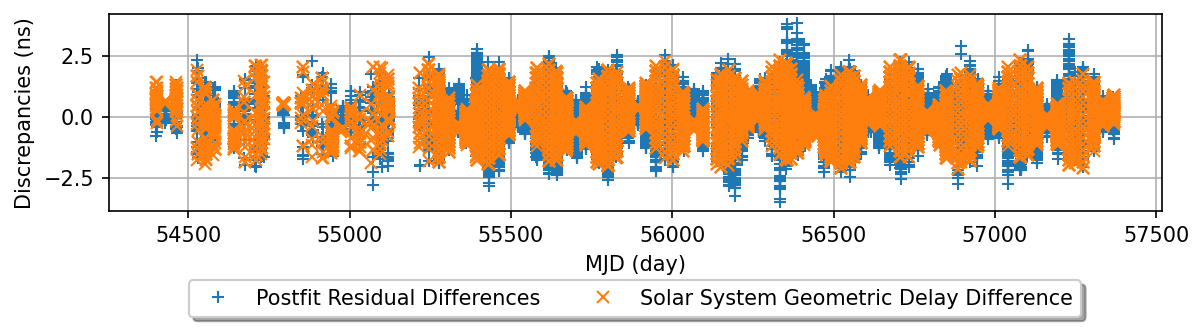

In [37]:
diff_solar = PINT_solar + tempo2_solar["roemer"] * u.s
plt.figure(figsize=(8, 2.5), dpi=150)
plt.plot(mjds, (tp2_diff_post2 - tp2_diff_post2.mean()).to_value(u.ns), "+")
plt.plot(
    mjds,
    (diff_solar - diff_solar.mean()).to_value(u.ns, equivalencies=[(ls, u.s)]),
    "x",
)

plt.xlabel("MJD (day)")
plt.ylabel("Discrepancies (ns)")
# plt.title('PSR J1600-3053 postfit residual differences between PINT and TEMPO2')
plt.grid(True)
plt.legend(
    ["Postfit Residual Differences", "Solar System Geometric Delay Difference"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    shadow=True,
    ncol=2,
)
plt.tight_layout()
plt.savefig("solar_geo")